In [1]:
import numpy as np
import h5py
from tqdm import tqdm
import pandas as pd
import random
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Computer Modern Roman"]})

from utils import global_monotonicity_violation, global_convexity_violation, peaking_detection, flat_detector
from meta_feature import dataset_ids_CC18, anchor_list_denser, learner_zoo_abbreviation, learner_zoo

### LCDB 1.1

In [2]:
file_paths = Path.cwd() / '../dataset/LCDB11_ER_CC18_24.hdf5'
dataset = h5py.File(file_paths , 'r')['error rate'][...] 
# dataset_nofs, dataset_minmaxfs, dataset_standardfs 
datasets = [dataset[..., 0, 0], dataset[..., 1, 0], dataset[..., 2, 0]]

In [3]:
results = []
for DATASET in datasets: 
    mono_matrix_y, _ = global_monotonicity_violation(DATASET)
    conv_matrix, _, _, _ = global_convexity_violation(DATASET)
    dipping_matrix_y, _ = global_monotonicity_violation(DATASET, dipping = True)
    flat_matrix, _ = flat_detector(DATASET)
    peak_matrix, _, _, _ = peaking_detection(DATASET)
    results.append({
        "mono_matrix_y": mono_matrix_y,
        "conv_matrix": conv_matrix,
        "dipping_matrix_y": dipping_matrix_y,
        "peak_matrix": peak_matrix,
        "flat_matrix": flat_matrix
    })


100%|██████████| 72/72 [01:22<00:00,  1.15s/it]


### Statistics Table

In [16]:
# Dummy is filtered out in  this cell

for result in results:
    mono_matrix_y = result["mono_matrix_y"][0:23, :]
    conv_matrix = result["conv_matrix"][0:23, :]
    flat_matrix = result["flat_matrix"][0:23, :]
    dipping_matrix_y = result["dipping_matrix_y"][0:23, :]
    peak_matrix = result["peak_matrix"][0:23, :]

    missing = (np.isnan(mono_matrix_y).sum() / mono_matrix_y.size) * 100
    print(f"Missing Ratio: {missing:.1f}%") 
    print(f"Flat: {(np.sum(flat_matrix == -1) / flat_matrix.size) * 100:.1f}%")
    # print(f"Monotone (M): {(np.sum(mono_matrix_y == 0) / mono_matrix_y.size) * 100:.1f}%")
    # print(f"Convex (C): {(np.sum(conv_matrix == 0) / conv_matrix.size) * 100:.1f}%")
    # print(f"Well-behaved (M+C): {(np.sum((conv_matrix == 0) & (mono_matrix_y == 0)) / mono_matrix_y.size) * 100:.1f}%")
    print(f"Non-Monotone (NM): {(np.sum(mono_matrix_y > 0) / mono_matrix_y.size) * 100:.1f}%")
    print(f"Non-Convex (NC): {(np.sum(conv_matrix > 0) / conv_matrix.size) * 100:.1f}%")
    ill_behaved = np.logical_or(mono_matrix_y > 0, conv_matrix > 0)
    print(f"Ill-behaved (NM | NC): {(np.sum(ill_behaved) / conv_matrix.size) * 100:.1f}%")
    print(f"Peaking: {(np.sum(peak_matrix > 0) / peak_matrix.size) * 100:.1f}%")
    print(f"Dipping: {(np.sum(dipping_matrix_y > 0) / dipping_matrix_y.size) * 100:.1f}%")
    print("-----------------------")

Missing Ratio: 3.0%
Flat: 8.5%
Non-Monotone (NM): 10.4%
Non-Convex (NC): 10.8%
Ill-behaved (NM | NC): 14.4%
Peaking: 7.4%
Dipping: 7.8%
-----------------------
Missing Ratio: 0.4%
Flat: 7.9%
Non-Monotone (NM): 11.0%
Non-Convex (NC): 9.9%
Ill-behaved (NM | NC): 14.2%
Peaking: 6.6%
Dipping: 9.5%
-----------------------
Missing Ratio: 8.7%
Flat: 5.3%
Non-Monotone (NM): 9.5%
Non-Convex (NC): 8.8%
Ill-behaved (NM | NC): 11.8%
Peaking: 5.7%
Dipping: 7.2%
-----------------------


In [17]:
all_learner_stats = []

for result in results:
    mono_matrix_y = result["mono_matrix_y"]
    conv_matrix = result["conv_matrix"]
    flat_matrix = result["flat_matrix"]
    dipping_matrix_y = result["dipping_matrix_y"]
    peak_matrix = result["peak_matrix"]

    learner_stats = [{"learner": learner_zoo[i]} for i in range(24)]

    for i in range(24):
        mono_y_learner = mono_matrix_y[i, :]
        conv_learner = conv_matrix[i, :]
        flat_learner = flat_matrix[i, :]
        dipping_y_learner = dipping_matrix_y[i, :]
        peak_learner = peak_matrix[i, :]

        missing_learner = (np.isnan(mono_y_learner).sum() / mono_y_learner.size) * 100
        flat_percentage_learner = (np.sum(flat_learner == -1) / flat_learner.size) * 100
        
        non_mono_viola_percentage_learner = (np.sum(mono_y_learner > 0) / mono_y_learner.size) * 100
        non_conv_viola_percentage_learner = (np.sum(conv_learner > 0) / conv_learner.size) * 100
        ill_behaved_percentage_learner = (np.sum(np.logical_or(mono_y_learner > 0, conv_learner > 0)) / mono_y_learner.size) * 100
        peaking_percentage_learner = (np.sum(peak_learner > 0) / peak_learner.size) * 100
        dipping_percentage_learner = (np.sum(dipping_y_learner > 0) / dipping_y_learner.size) * 100

        learner_stats[i].update({
            "missing": missing_learner,
            "flat": flat_percentage_learner,
            # "monotone": mono_viola_percentage_learner,
            # "convex": conv_viola_percentage_learner,
            # "well_behaved": both_no_viola_percentage_learner,
            "non_monotone": non_mono_viola_percentage_learner,
            "non_convex": non_conv_viola_percentage_learner,
            "ill_behaved": ill_behaved_percentage_learner,
            "peaking": peaking_percentage_learner,
            "dipping": dipping_percentage_learner,
        })

    all_learner_stats.append({
        "learner_stats": learner_stats
    })

# for dataset_idx, dataset_result in enumerate(all_learner_stats):
#     print(f"=== Dataset {dataset_idx + 1} ===")
#     for learner_stat in dataset_result["learner_stats"]:
#         print(
#             f"Learner {learner_stat['learner']}: "
#             f"Missing={learner_stat['missing']:.1f}%, "
#             f"Flat={learner_stat['flat']:.1f}%, "
#             f"Non-Monotone={learner_stat['non_monotone']:.1f}%, "
#             f"Non-Convex={learner_stat['non_convex']:.1f}%, "
#             f"Ill-behaved={learner_stat['ill_behaved']:.1f}%, "
#             f"Peaking={learner_stat['peaking']:.1f}%, "
#             f"Dipping={learner_stat['dipping']:.1f}%"
#         )
#     print("\n")


In [ ]:
table_data = []

for i in range(24):  
    row = [learner_zoo[i]]  
    for dataset_result in all_learner_stats:
        learner_stat = dataset_result["learner_stats"][i]
        row.extend([
            f"{learner_stat['missing']:.1f}",
            f"{learner_stat['flat']:.1f}",
            f"{learner_stat['non_monotone']:.1f}",
            f"{learner_stat['non_convex']:.1f}",
            f"{learner_stat['ill_behaved']:.1f}",
            f"{learner_stat['peaking']:.1f}",
            f"{learner_stat['dipping']:.1f}",
        ])
    table_data.append(row)


latex_code = r"""
\begin{sidewaystable}
\caption{Statistics of each learner in LCDB 1.1 (no Data Leakage version)}
\label{tab:learner_stats}
\resizebox{\textwidth}{!}{ 
\begin{tabular}{lccccccccccccccccccccc}
\toprule
\multirow{2}{*}{Learner} 
# & \multicolumn{7}{c}{LCDB 1.1 FULL (265) no FS}               
# & \multicolumn{7}{c}{LCDB 1.1 FULL (265) min-max FS}           
# & \multicolumn{7}{c}{LCDB 1.1 FULL (265) standardization FS}       
\\
\cmidrule(lr){2-8} \cmidrule(lr){9-15} \cmidrule(lr){16-22}
& Missing & Flat & Non-Monotone & Non-Convex & Ill-behaved & Peaking & Dipping
& Missing & Flat & Non-Monotone & Non-Convex & Ill-behaved & Peaking & Dipping
& Missing & Flat & Non-Monotone & Non-Convex & Ill-behaved & Peaking & Dipping
\\
\midrule
"""

for row in table_data:
    latex_code += " & ".join(row) + r" \\" + "\n"


latex_code += r"""
\bottomrule
\end{tabular}
} 
\end{sidewaystable}
"""


print(latex_code)



\begin{sidewaystable}
\caption{Statistics of each learner in LCDB 1.1 (no Data Leakage version)}
\label{tab:learner_stats}
\resizebox{\textwidth}{!}{ 
\begin{tabular}{lccccccccccccccccccccc}
\toprule
\multirow{2}{*}{Learner} 
& \multicolumn{7}{c}{LCDB 1.1 FULL (265) no FS}               
& \multicolumn{7}{c}{LCDB 1.1 FULL (265) min-max FS}           
& \multicolumn{7}{c}{LCDB 1.1 FULL (265) standardization FS}       
\\
\cmidrule(lr){2-8} \cmidrule(lr){9-15} \cmidrule(lr){16-22}
& Missing & Flat & Non-Monotone & Non-Convex & Ill-behaved & Peaking & Dipping
& Missing & Flat & Non-Monotone & Non-Convex & Ill-behaved & Peaking & Dipping
& Missing & Flat & Non-Monotone & Non-Convex & Ill-behaved & Peaking & Dipping
\\
\midrule
SVM_Linear & 0.4 & 3.4 & 3.8 & 4.5 & 5.7 & 2.6 & 2.6 & 0.4 & 7.9 & 2.6 & 2.3 & 3.4 & 1.1 & 1.1 & 0.0 & 2.3 & 3.4 & 4.2 & 5.3 & 1.9 & 2.3 \\
SVM_Poly & 0.4 & 17.4 & 3.4 & 6.4 & 7.9 & 3.8 & 3.4 & 0.4 & 6.0 & 1.5 & 2.6 & 3.8 & 0.8 & 1.9 & 0.0 & 12.8 & 2.3 & 5.3 & 6.0 &

In [20]:
for dataset_idx, dataset_result in enumerate(all_learner_stats):
    print(f"=== Ranking for Dataset {dataset_idx + 1} (by Ill-behaved %) ===")
    
    sorted_stats = sorted(dataset_result["learner_stats"], key=lambda x: x["ill_behaved"])
    
    for rank, learner_stat in enumerate(sorted_stats, start=1):
        print(f"{rank:>2}. {learner_stat['learner']:<35} Ill-behaved = {learner_stat['ill_behaved']:.1f}%")
    
    print("\n")


=== Ranking for Dataset 1 (by Ill-behaved %) ===
 1. Decision Tree                       Ill-behaved = 1.5%
 2. ExtraTree                           Ill-behaved = 1.9%
 3. ens.GradientBoosting                Ill-behaved = 1.9%
 4. ens.RandomForest                    Ill-behaved = 3.0%
 5. SGDClassifier                       Ill-behaved = 3.4%
 6. ens.ExtraTrees                      Ill-behaved = 3.4%
 7. Perceptron                          Ill-behaved = 3.8%
 8. KNN                                 Ill-behaved = 3.8%
 9. LogisticRegression                  Ill-behaved = 5.3%
10. SVM_Linear                          Ill-behaved = 5.7%
11. SVM_Poly                            Ill-behaved = 7.9%
12. MultinomialNB                       Ill-behaved = 7.9%
13. NearestCentroid                     Ill-behaved = 7.9%
14. ComplementNB                        Ill-behaved = 8.3%
15. PassiveAggressive                   Ill-behaved = 9.4%
16. SVM_RBF                             Ill-behaved = 15.8%
17. Ri

CC-18 detail violation error

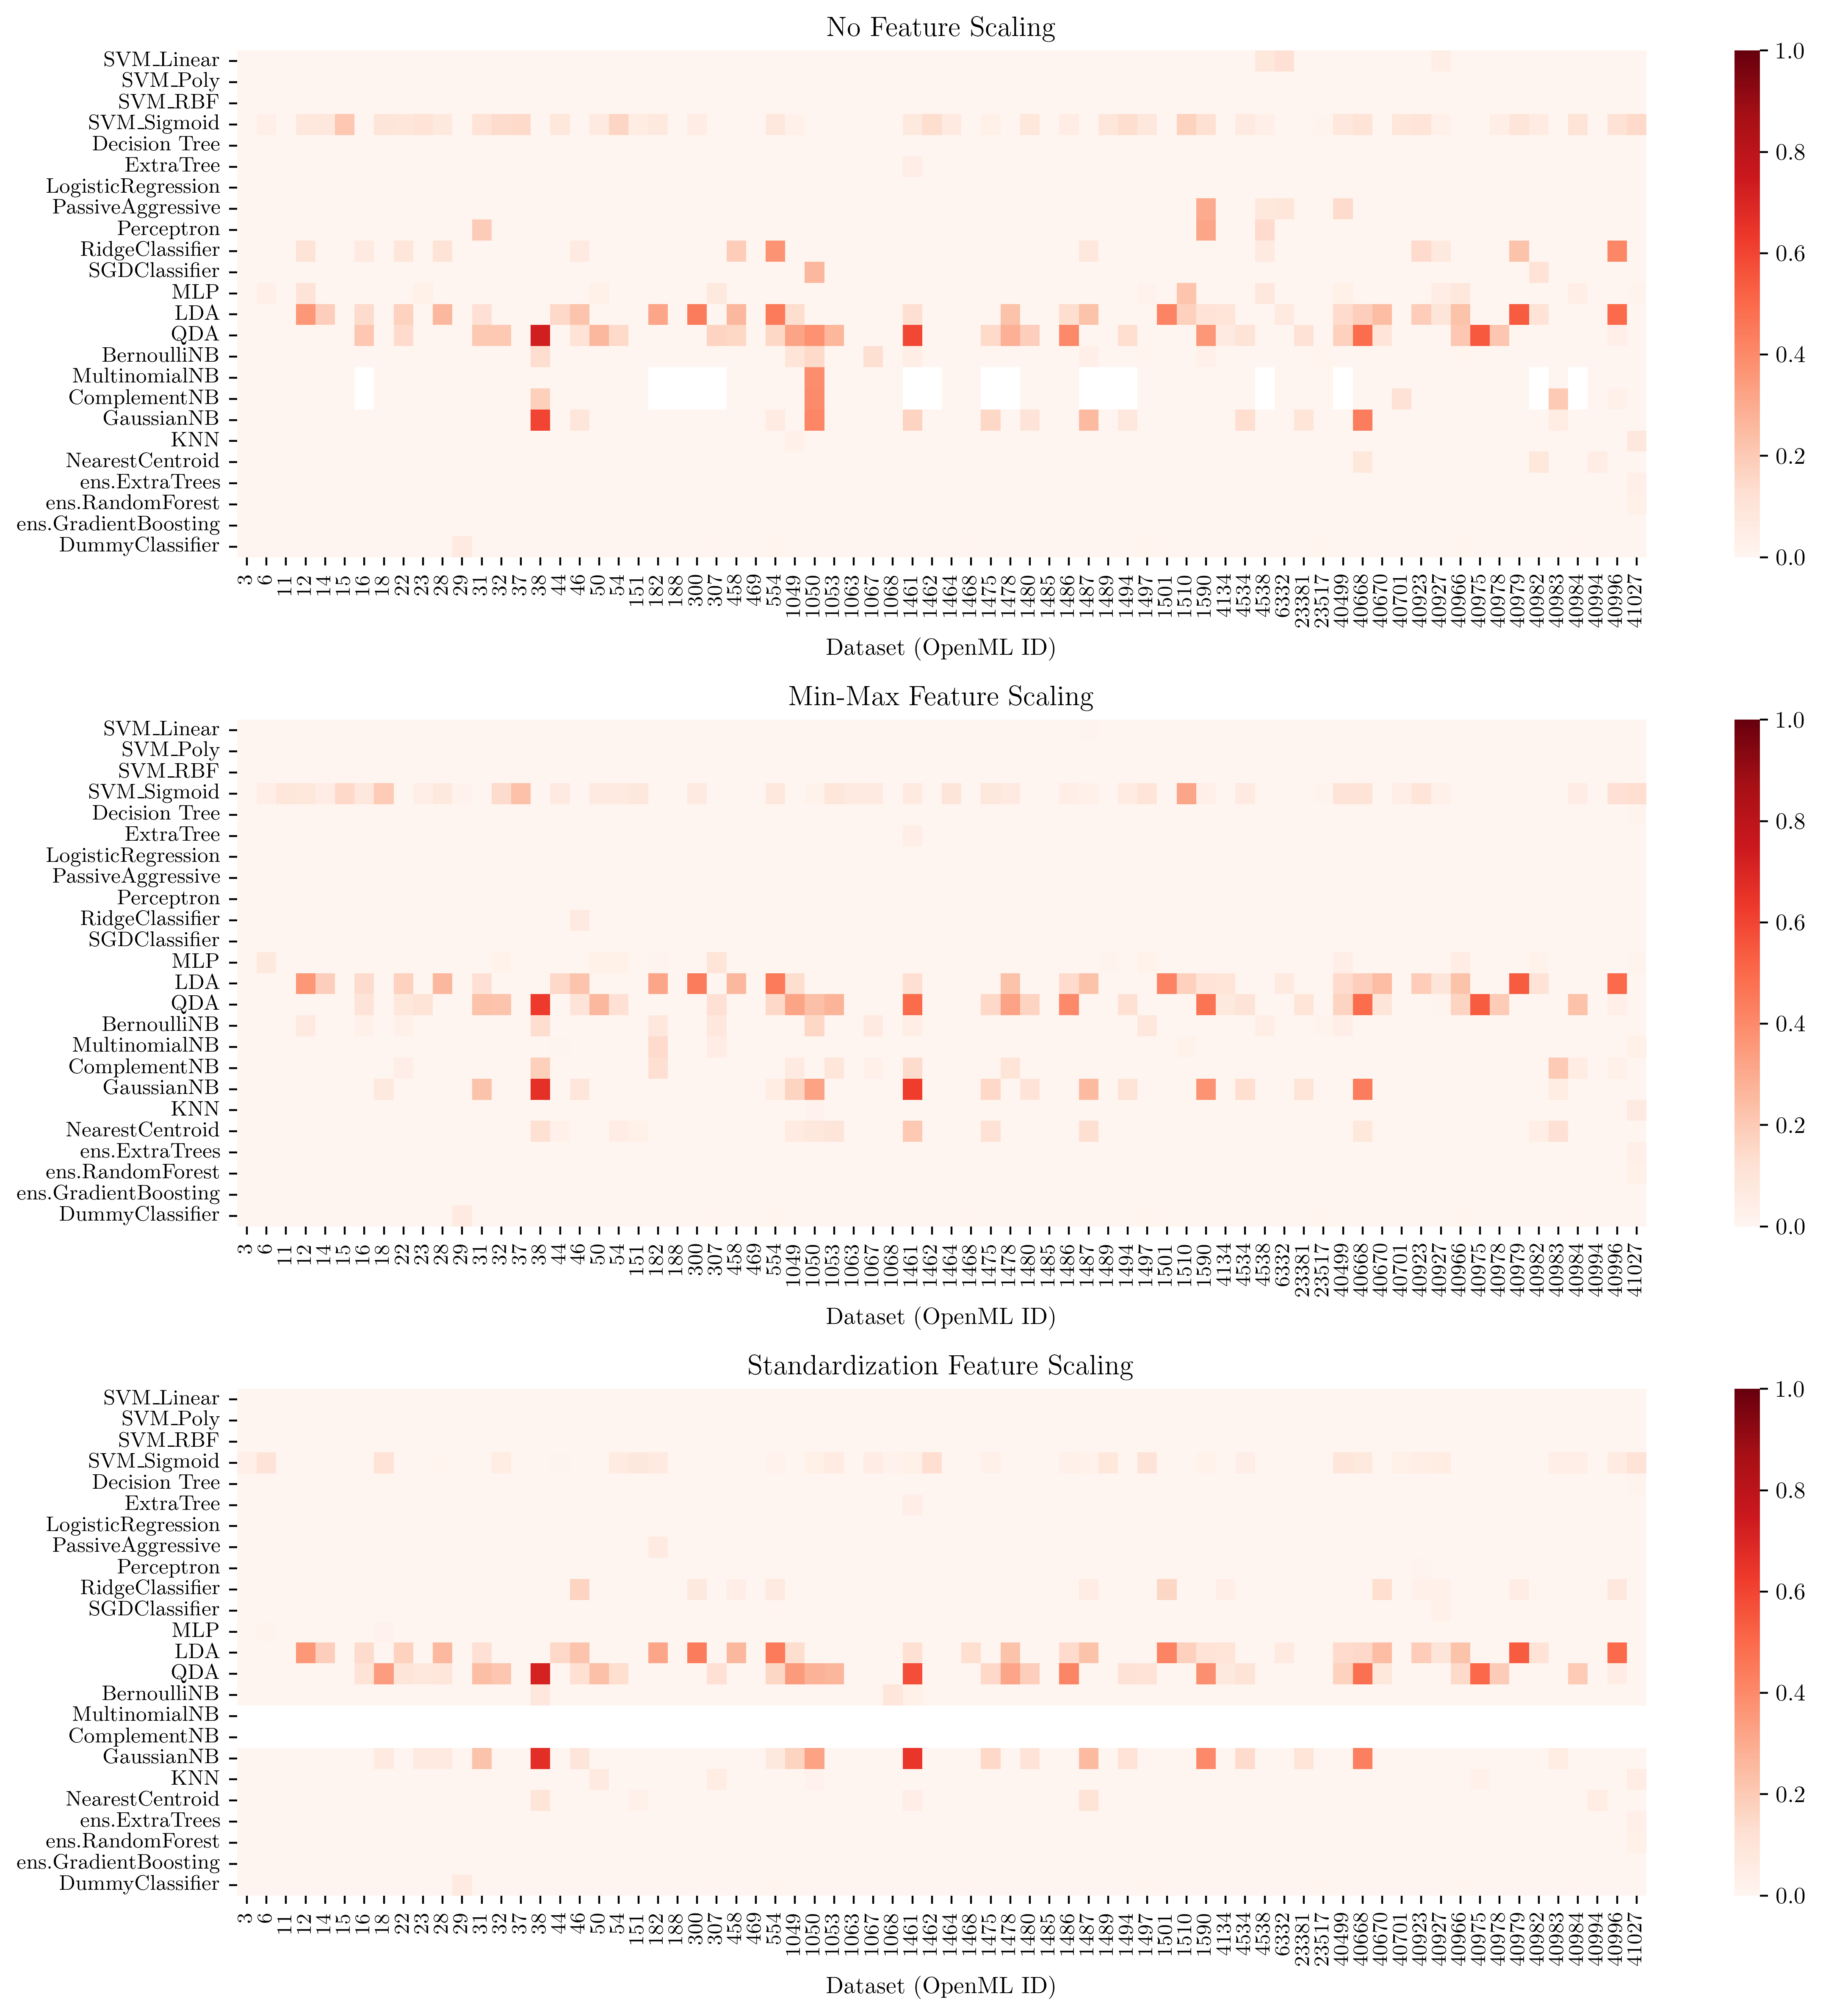

In [12]:
matrices = [results[0]["mono_matrix_y"], results[1]["mono_matrix_y"], results[2]["mono_matrix_y"]]
titles = ['No Feature Scaling', 'Min-Max Feature Scaling', 'Standardization Feature Scaling']

fig, axes = plt.subplots(3, 1, figsize=(12, 12), dpi=400) 

for ax, matrix, title in zip(axes, matrices, titles):
    sns.heatmap(matrix, ax=ax, cmap="Reds", annot=False, cbar=True, vmin=0, vmax=1)
    ax.set_title(title)
    ax.set_yticks([y + 0.5 for y in range(len(learner_zoo))])
    ax.set_yticklabels(learner_zoo, rotation=0, fontsize=9)
    ax.set_xticks([x + 0.5 for x in range(len(dataset_ids_CC18))])
    ax.set_xticklabels(dataset_ids_CC18, rotation=90, fontsize=9)
    ax.set_xlabel('Dataset (OpenML ID)')
    # ax.set_ylabel('Learner')

plt.tight_layout()
plt.show()


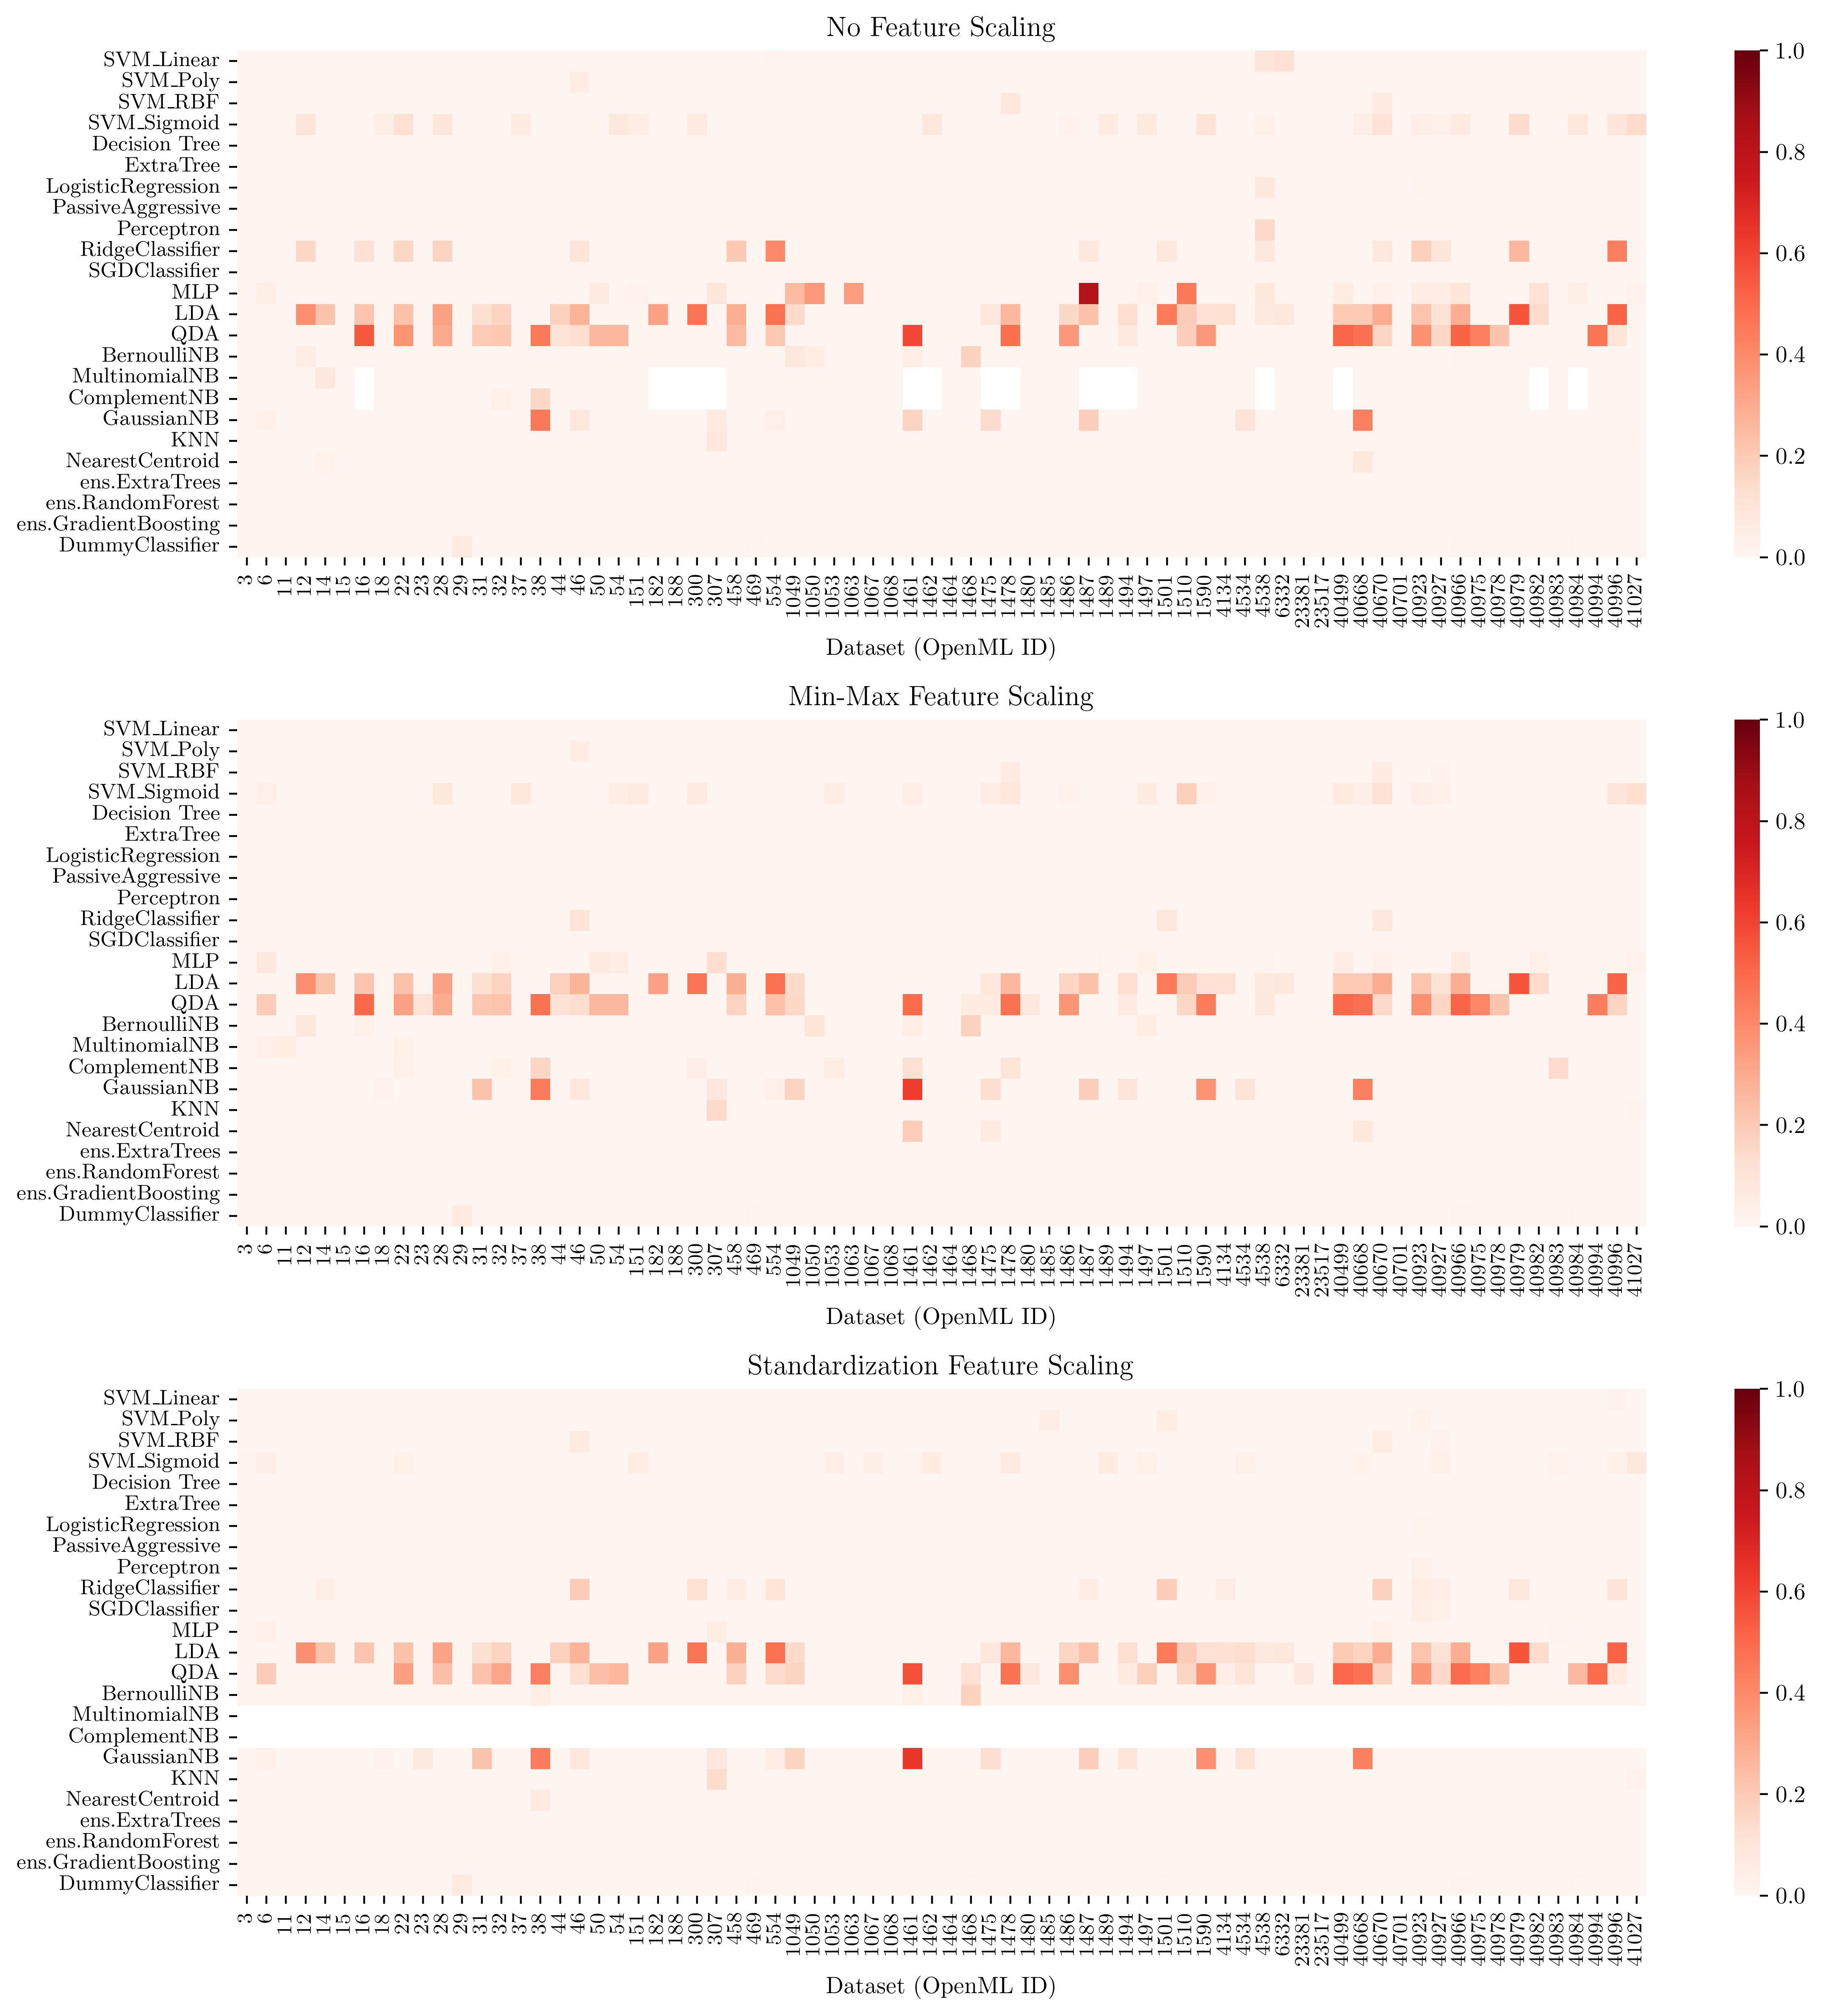

In [13]:
conv_matrices = [results[0]["conv_matrix"], results[1]["conv_matrix"], results[2]["conv_matrix"]]
titles = ['No Feature Scaling', 'Min-Max Feature Scaling', 'Standardization Feature Scaling']

fig, axes = plt.subplots(3, 1, figsize=(12, 12), dpi=400) 

for ax, matrix, title in zip(axes, conv_matrices, titles):
    sns.heatmap(matrix, ax=ax, cmap="Reds", annot=False, cbar=True, vmin=0, vmax=1)
    ax.set_title(title)
    ax.set_yticks([y + 0.5 for y in range(len(learner_zoo))])
    ax.set_yticklabels(learner_zoo, rotation=0, fontsize=9)
    ax.set_xticks([x + 0.5 for x in range(len(dataset_ids_CC18))])
    ax.set_xticklabels(dataset_ids_CC18, rotation=90, fontsize=9)
    ax.set_xlabel('Dataset (OpenML ID)')
    # ax.set_ylabel('Learner')

plt.tight_layout()
plt.show()


### Barchart of ill-behaved

No flat curve filter here

In [4]:
# filter some learner not a lot ill behaved
exclude_indices = [0, 1, 4, 5, 6, 8, 10, 13, 20, 21, 22 ,23]      # list(range(14, 18))  no Naive Bayes  13 QDA  23 DUMMY

Monotonicity Violation

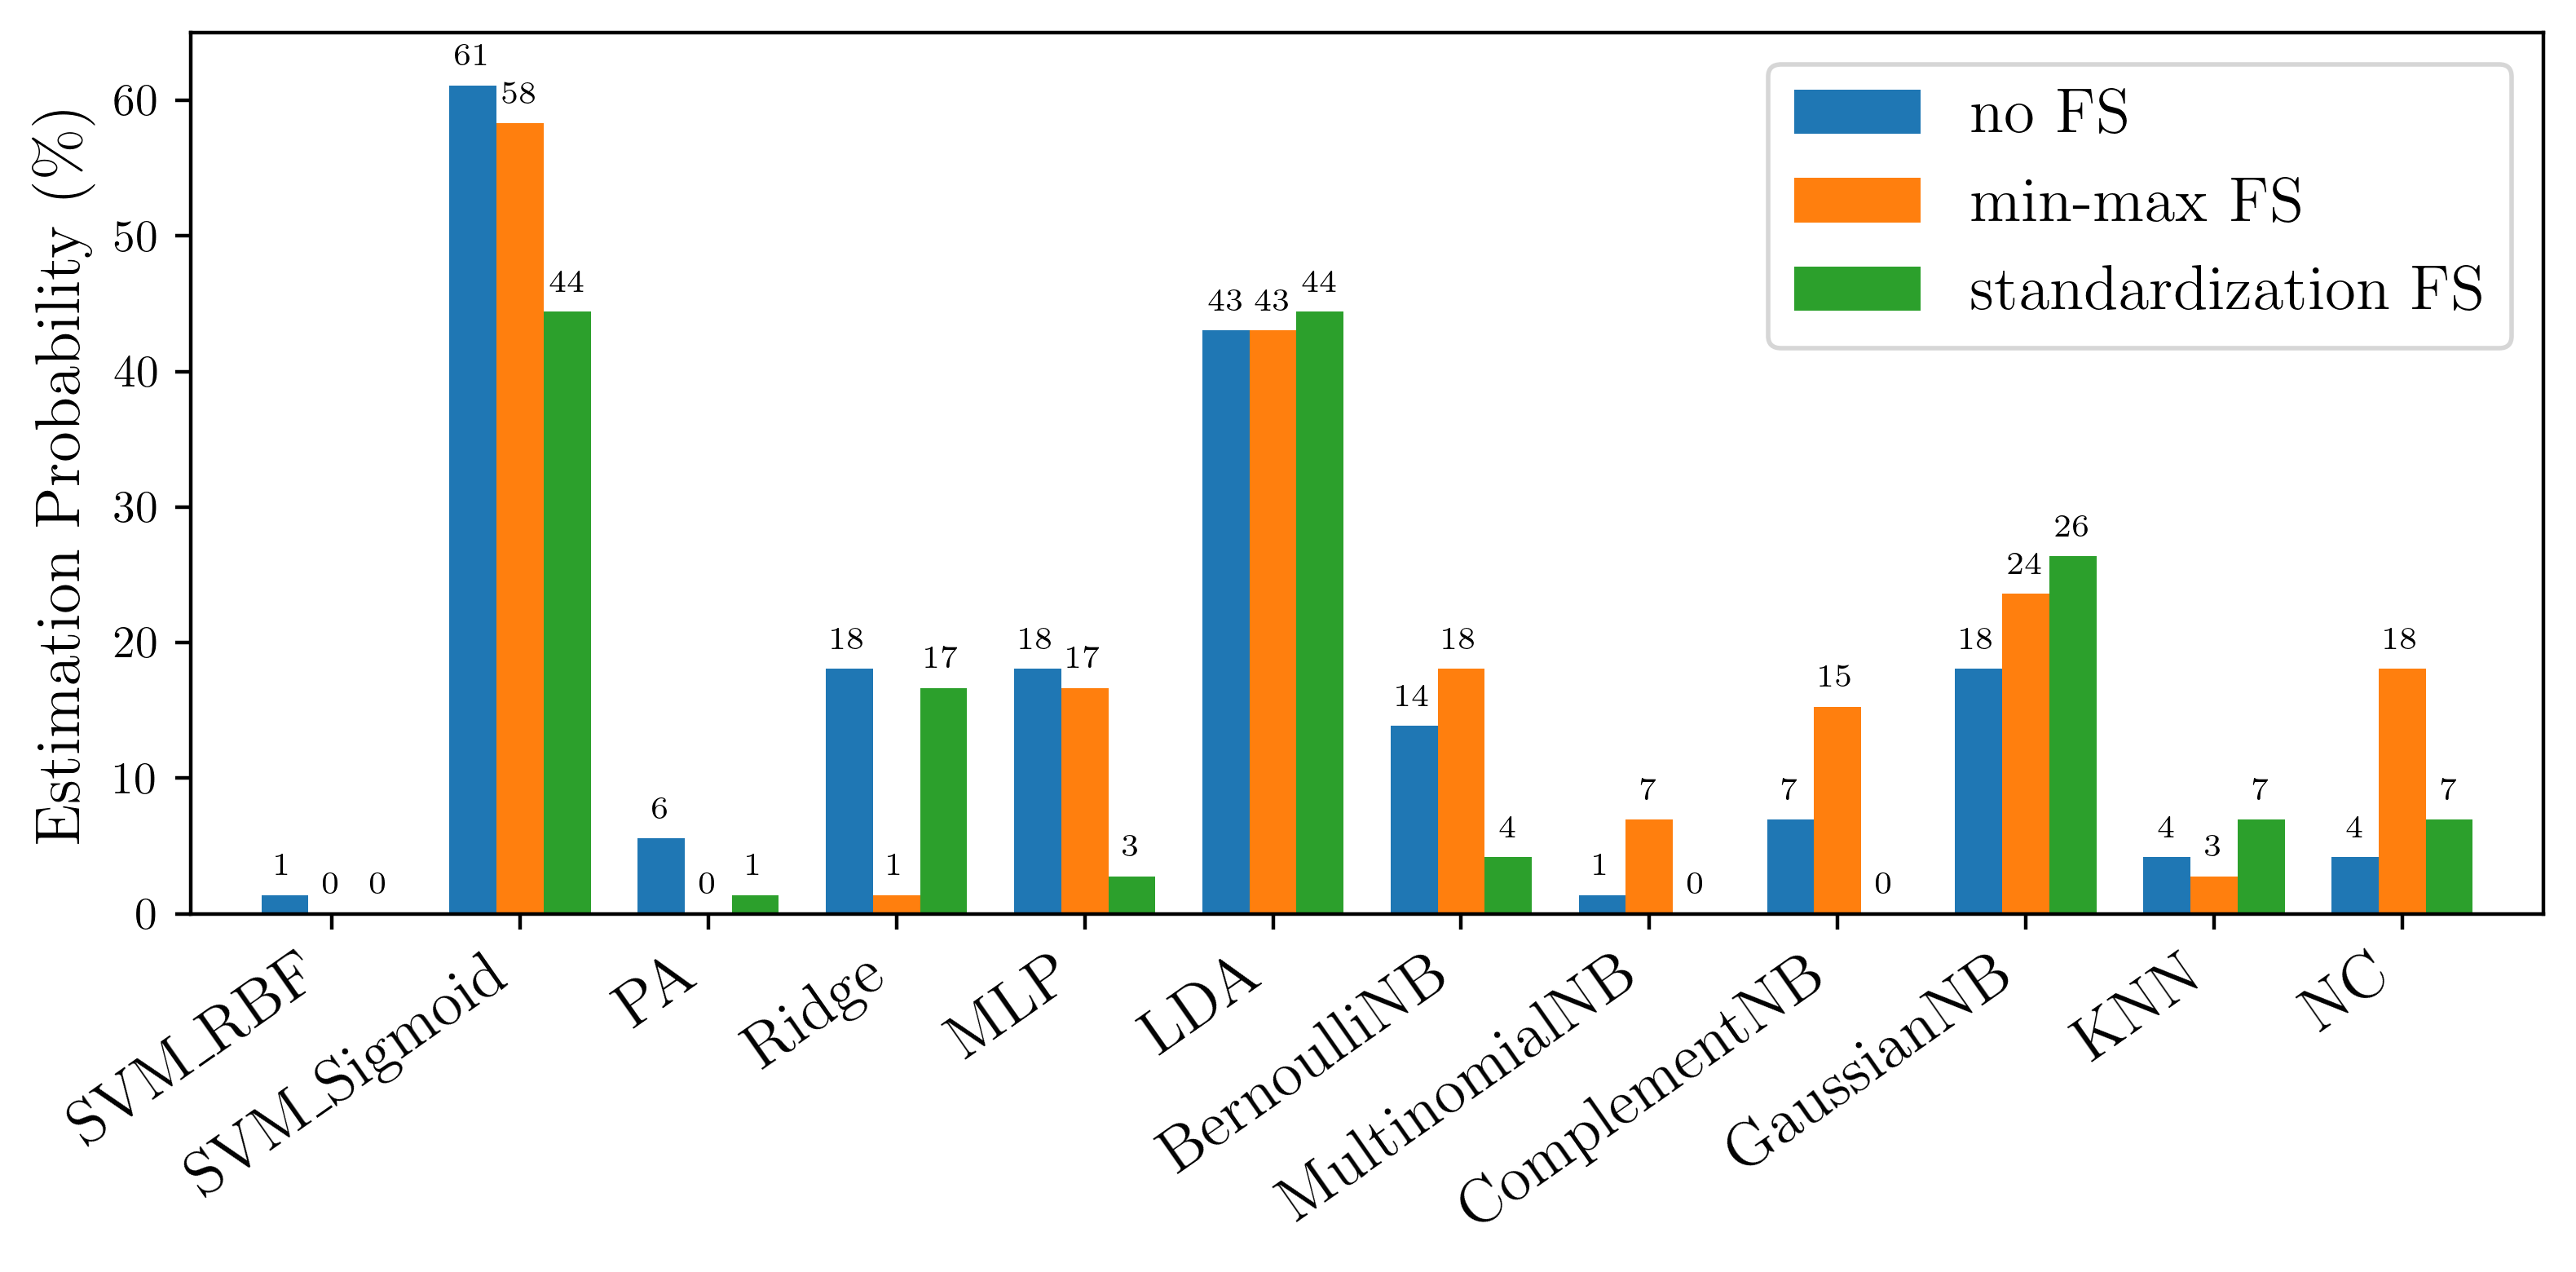

In [5]:
percentages_nofs = (np.sum(results[0]["mono_matrix_y"] > 0, axis=1) / results[0]["mono_matrix_y"].shape[1]) * 100
percentages_minmaxfs = (np.sum(results[1]["mono_matrix_y"] > 0, axis=1) / results[1]["mono_matrix_y"].shape[1]) * 100
percentages_standardfs = (np.sum(results[2]["mono_matrix_y"] > 0, axis=1) / results[2]["mono_matrix_y"].shape[1]) * 100

learner_zoo_filtered = [learner for i, learner in enumerate(learner_zoo_abbreviation) if i not in exclude_indices]
percentages_nofs = [val for i, val in enumerate(percentages_nofs) if i not in exclude_indices]
percentages_minmaxfs = [val for i, val in enumerate(percentages_minmaxfs) if i not in exclude_indices]
percentages_standardfs = [val for i, val in enumerate(percentages_standardfs) if i not in exclude_indices]

fig, ax = plt.subplots(figsize=(8, 4), dpi=400)     # (11, 5)

width = 0.25
x = np.arange(len(learner_zoo_filtered))  

bar1 = ax.bar(x - width,    percentages_nofs,       width, label='no FS')
bar2 = ax.bar(x ,           percentages_minmaxfs,   width, label='min-max FS')
bar3 = ax.bar(x + width,    percentages_standardfs, width, label='standardization FS')

ax.set_ylabel(r'Estimation Probability (\%)', fontsize = 14)
ax.set_ylim(0,65)
ax.set_xticks(x)
ax.set_xlim(x[0] - 3 * width, x[-1] + 3 * width)    # set tighter x-axis limits
ax.set_xticklabels(learner_zoo_filtered, rotation=35, ha='right', fontsize = 14)  
ax.legend(fontsize = 14)



# percentage
def autolabel(bars):
    for rect in bars:
        height = rect.get_height()
        # if height > 0:  # only annotate bars with a height greater than 0
        ax.annotate(f'{height:.0f}',    # integer
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points", ha='center', va='bottom', 
                    fontsize = 7)
autolabel(bar1)
autolabel(bar2)
autolabel(bar3)
fig.tight_layout()
plt.show()


Convexity Violation

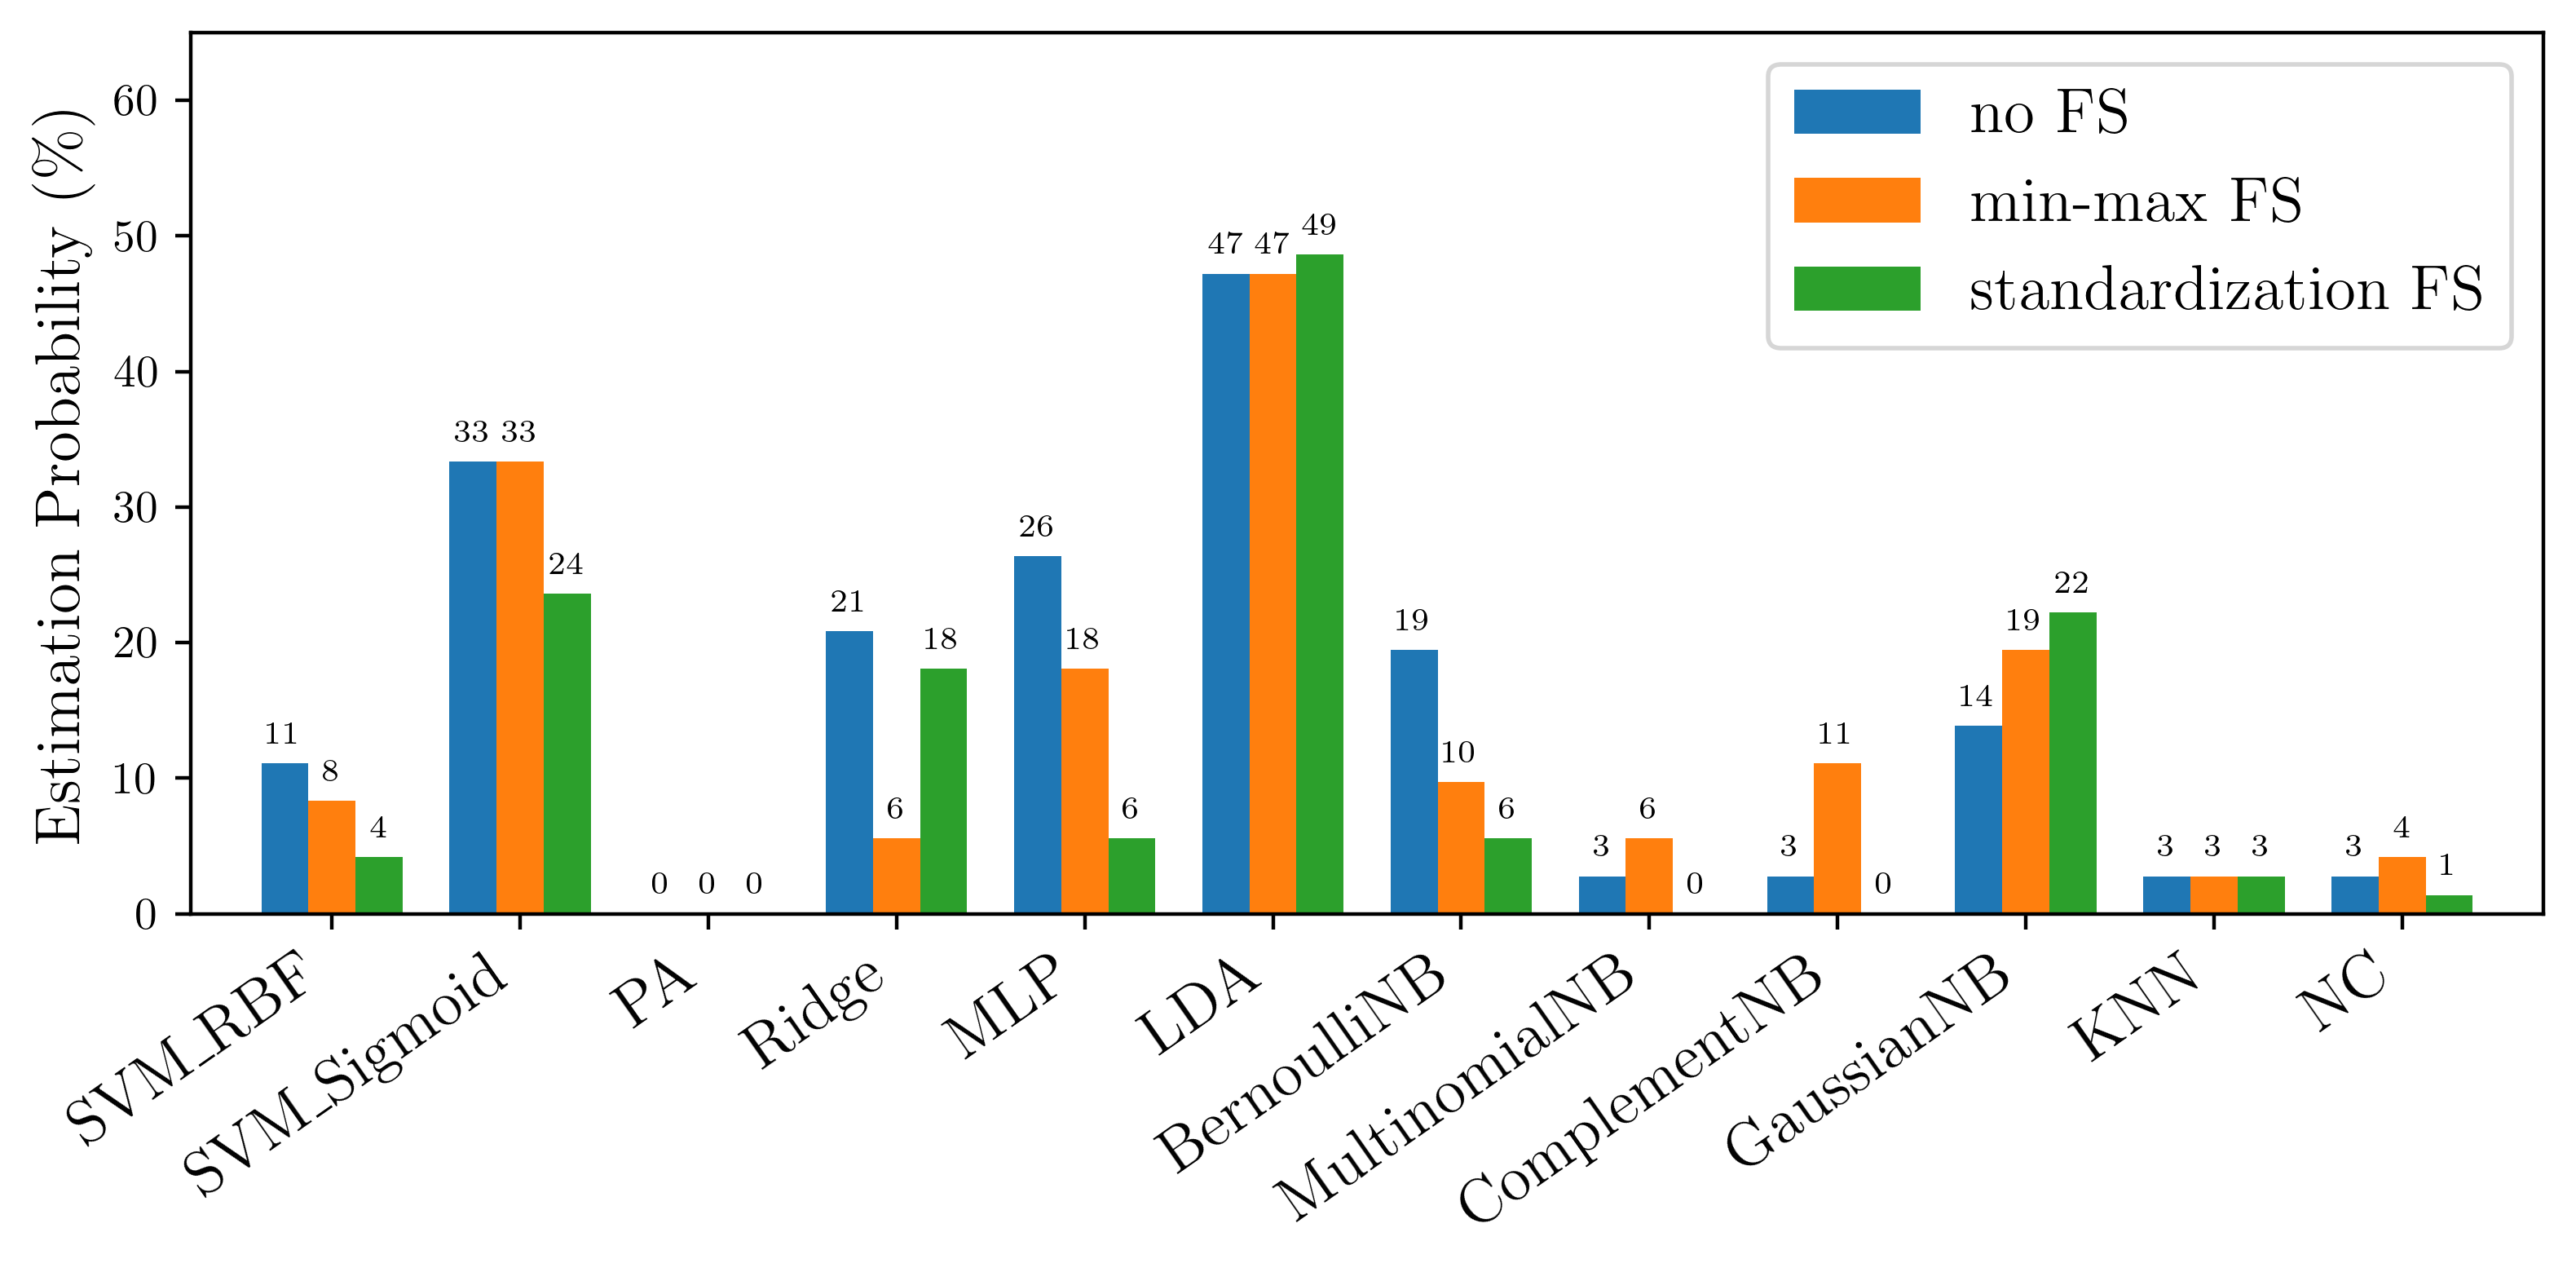

In [6]:
percentages_nofs = (np.sum(results[0]["conv_matrix"] > 0, axis=1) / results[0]["conv_matrix"].shape[1]) * 100
percentages_minmaxfs = (np.sum(results[1]["conv_matrix"] > 0, axis=1) / results[1]["conv_matrix"].shape[1]) * 100
percentages_standardfs = (np.sum(results[2]["conv_matrix"] > 0, axis=1) / results[2]["conv_matrix"].shape[1]) * 100

learner_zoo_filtered = [learner for i, learner in enumerate(learner_zoo_abbreviation) if i not in exclude_indices]
percentages_nofs = [val for i, val in enumerate(percentages_nofs) if i not in exclude_indices]
percentages_minmaxfs = [val for i, val in enumerate(percentages_minmaxfs) if i not in exclude_indices]
percentages_standardfs = [val for i, val in enumerate(percentages_standardfs) if i not in exclude_indices]


fig, ax = plt.subplots(figsize=(8, 4), dpi=400)

width = 0.25
x = np.arange(len(learner_zoo_filtered))  

bar1 = ax.bar(x - width,    percentages_nofs,       width, label='no FS')
bar2 = ax.bar(x ,           percentages_minmaxfs,   width, label='min-max FS')
bar3 = ax.bar(x + width,    percentages_standardfs, width, label='standardization FS')

ax.set_ylabel(r'Estimation Probability (\%)', fontsize = 14)
ax.set_ylim(0,65)
ax.set_xticks(x)
ax.set_xlim(x[0] - 3 * width, x[-1] + 3 * width)    # set tighter x-axis limits
ax.set_xticklabels(learner_zoo_filtered, rotation=35, ha='right', fontsize = 14)  
ax.legend(fontsize = 14)

# percentage
def autolabel(bars):
    for rect in bars:
        height = rect.get_height()
        # if height > 0:  # only annotate bars with a height greater than 0
        ax.annotate(f'{height:.0f}',    # integer
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points", ha='center', va='bottom', 
                    fontsize = 7)
autolabel(bar1)
autolabel(bar2)
autolabel(bar3)
fig.tight_layout()
plt.show()


Peaking

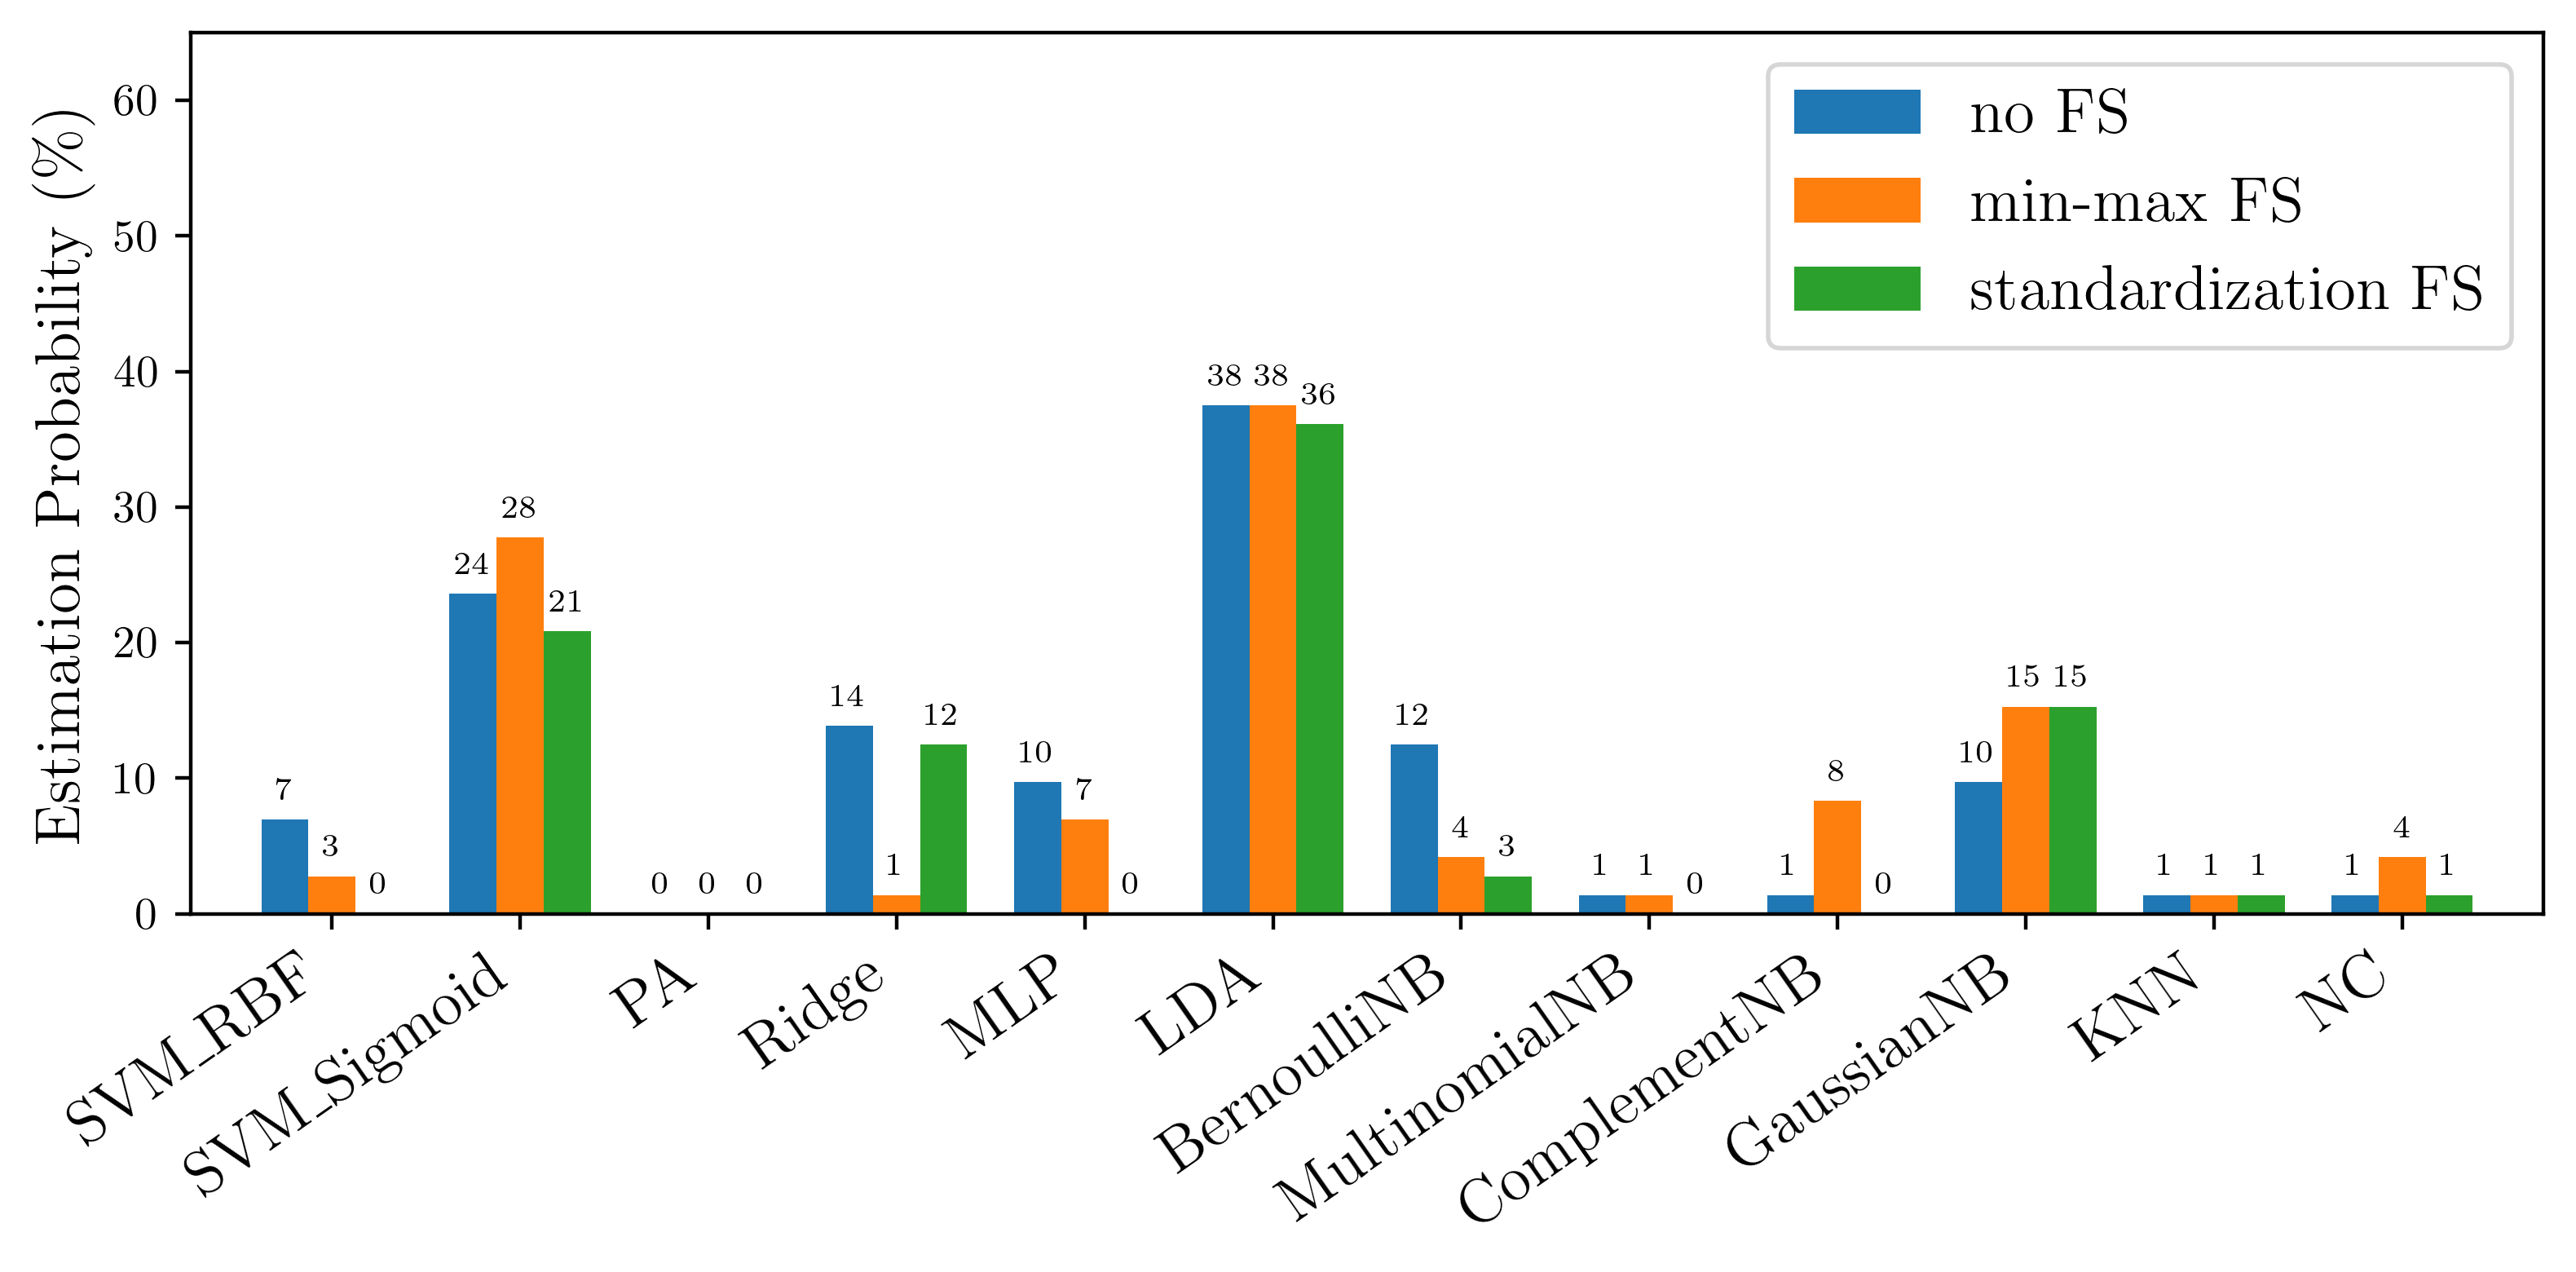

In [7]:
percentages_nofs = (np.sum(results[0]["peak_matrix"] > 0, axis=1) / results[0]["peak_matrix"].shape[1]) * 100
percentages_minmaxfs = (np.sum(results[1]["peak_matrix"] > 0, axis=1) / results[1]["peak_matrix"].shape[1]) * 100
percentages_standardfs = (np.sum(results[2]["peak_matrix"] > 0, axis=1) / results[2]["peak_matrix"].shape[1]) * 100

# filter some learner
exclude_indices = [0, 1, 4, 5, 6, 8, 10, 13, 20, 21, 22 ,23]      # list(range(14, 18))  no Naive Bayes  13 QDA  23 DUMMY
learner_zoo_filtered = [learner for i, learner in enumerate(learner_zoo_abbreviation) if i not in exclude_indices]
percentages_nofs = [val for i, val in enumerate(percentages_nofs) if i not in exclude_indices]
percentages_minmaxfs = [val for i, val in enumerate(percentages_minmaxfs) if i not in exclude_indices]
percentages_standardfs = [val for i, val in enumerate(percentages_standardfs) if i not in exclude_indices]

fig, ax = plt.subplots(figsize=(8, 4), dpi=400)

width = 0.25
x = np.arange(len(learner_zoo_filtered))  

bar1 = ax.bar(x - width,    percentages_nofs,       width, label='no FS')
bar2 = ax.bar(x ,           percentages_minmaxfs,   width, label='min-max FS')
bar3 = ax.bar(x + width,    percentages_standardfs, width, label='standardization FS')

ax.set_ylabel(r'Estimation Probability (\%)', fontsize = 14)
ax.set_ylim(0,65)
ax.set_xticks(x)
ax.set_xlim(x[0] - 3 * width, x[-1] + 3 * width)    # set tighter x-axis limits
ax.set_xticklabels(learner_zoo_filtered, rotation=35, ha='right', fontsize = 14)  
ax.legend(loc = 'best',fontsize = 14)

# percentage
def autolabel(bars):
    for rect in bars:
        height = rect.get_height()
        # if height > 0:  # only annotate bars with a height greater than 0
        ax.annotate(f'{height:.0f}',    # integer
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points", ha='center', va='bottom', 
                    fontsize = 7)
autolabel(bar1)
autolabel(bar2)
autolabel(bar3)
fig.tight_layout()
plt.show()


Dipping

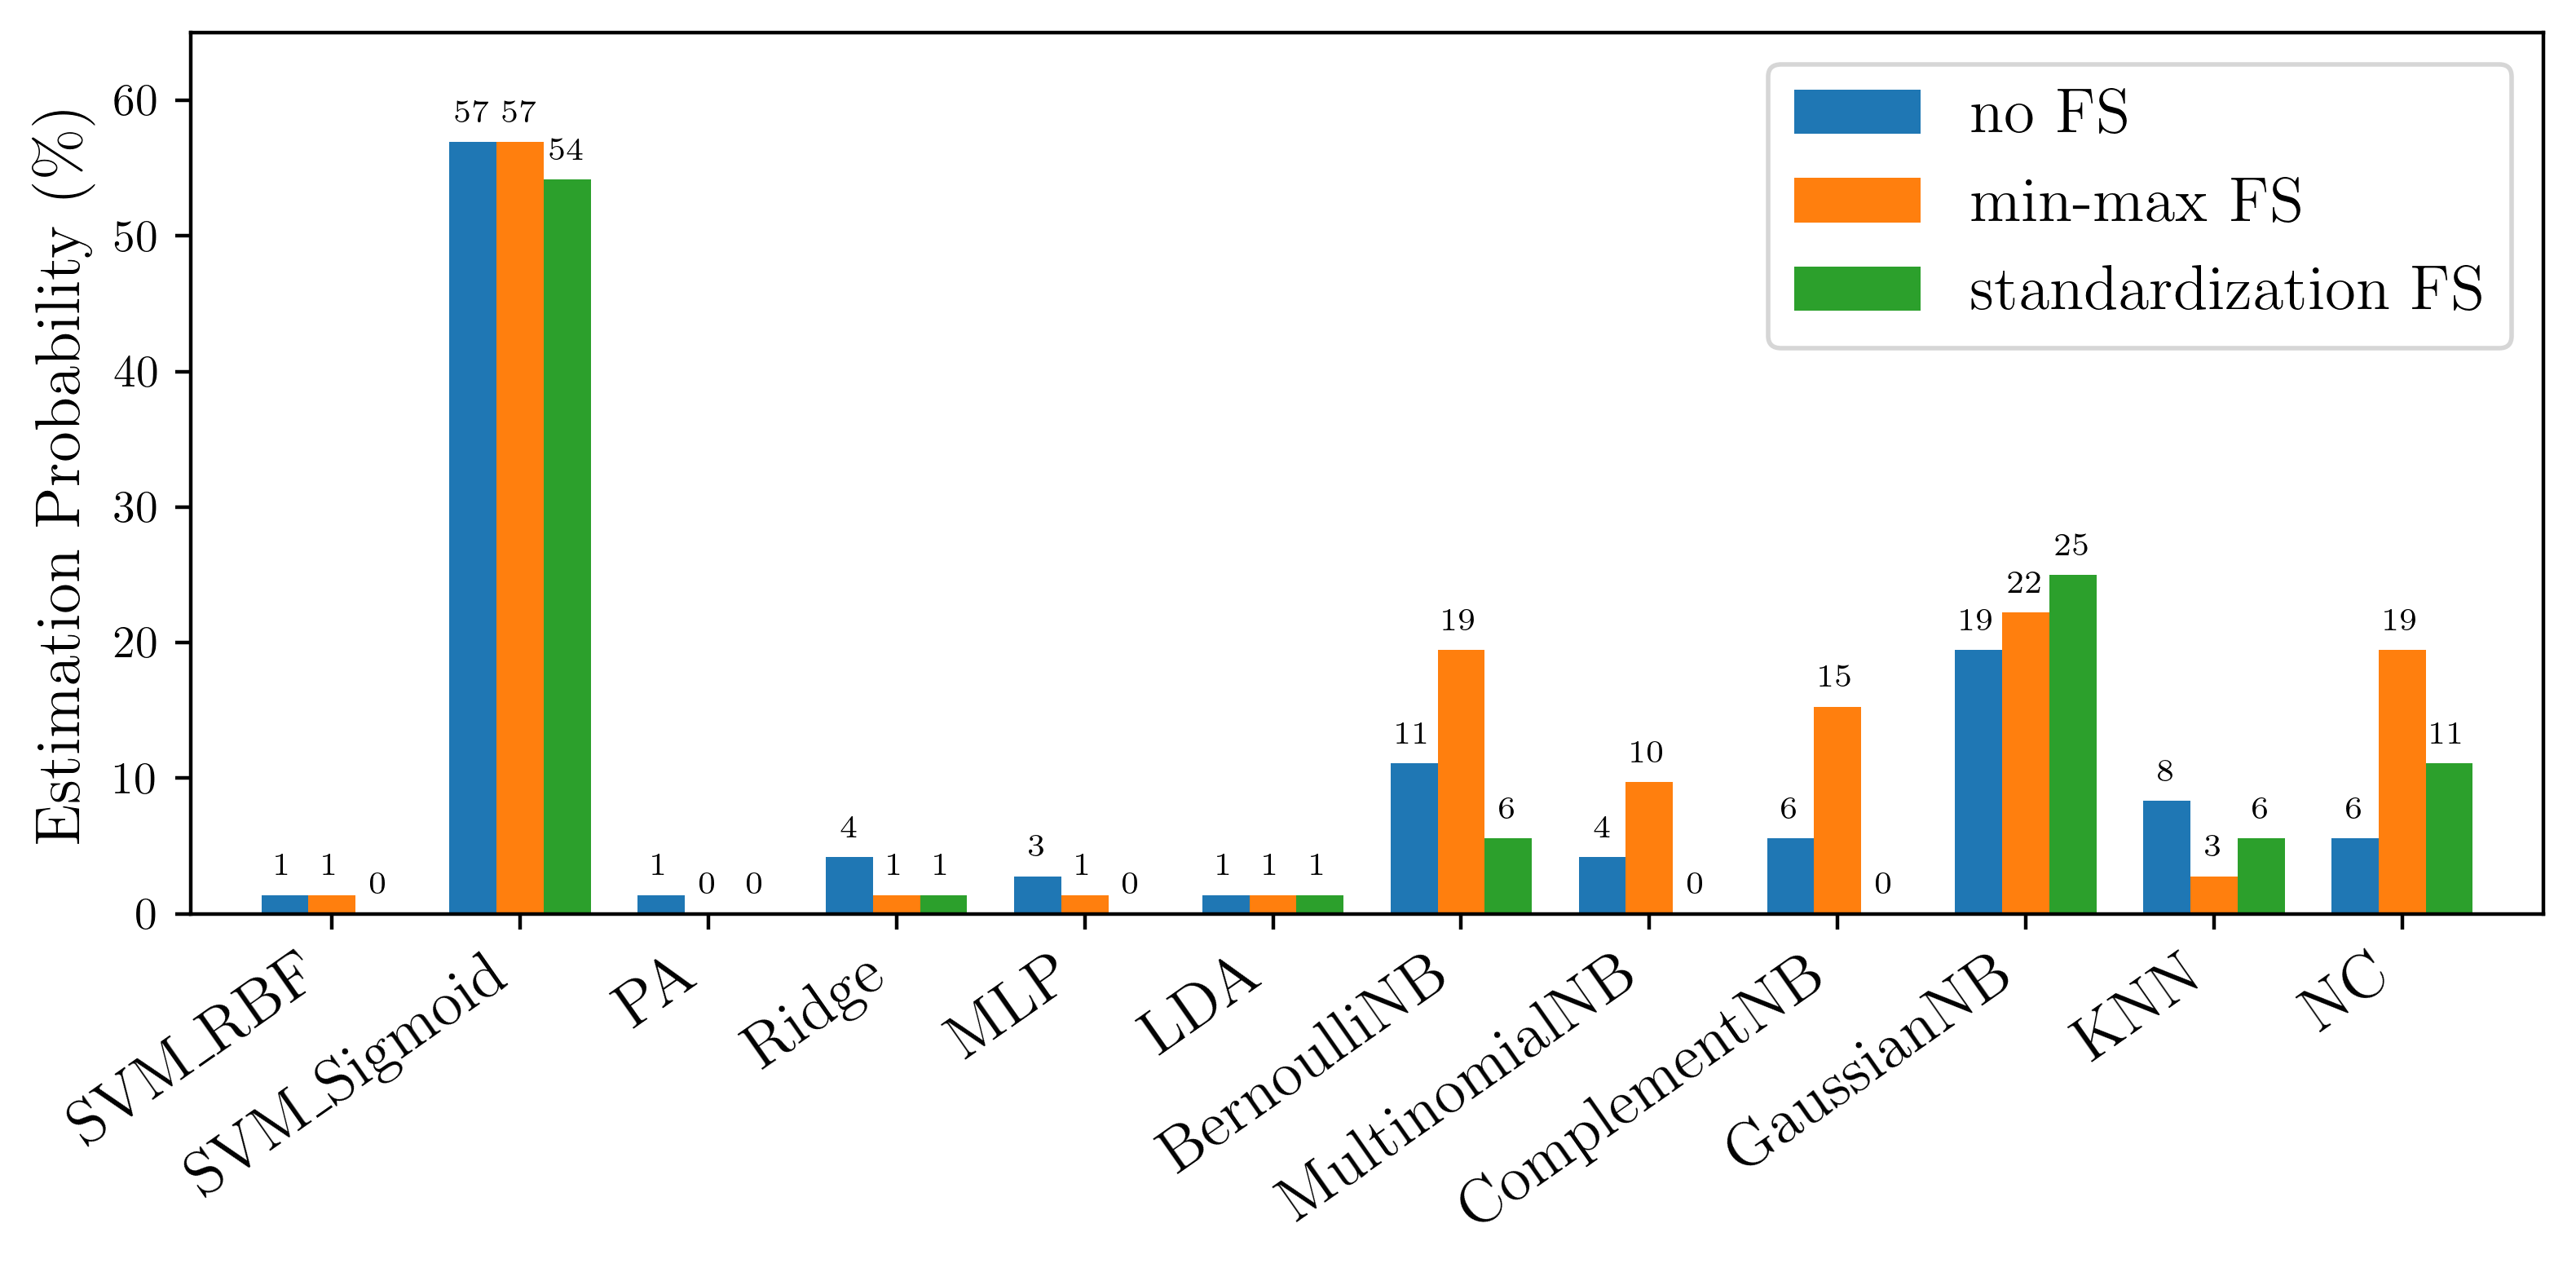

In [8]:
percentages_nofs = (np.sum(results[0]["dipping_matrix_y"] > 0, axis=1) / results[0]["dipping_matrix_y"].shape[1]) * 100
percentages_minmaxfs = (np.sum(results[1]["dipping_matrix_y"] > 0, axis=1) / results[1]["dipping_matrix_y"].shape[1]) * 100
percentages_standardfs = (np.sum(results[2]["dipping_matrix_y"] > 0, axis=1) / results[2]["dipping_matrix_y"].shape[1]) * 100

learner_zoo_filtered = [learner for i, learner in enumerate(learner_zoo_abbreviation) if i not in exclude_indices]
percentages_nofs = [val for i, val in enumerate(percentages_nofs) if i not in exclude_indices]
percentages_minmaxfs = [val for i, val in enumerate(percentages_minmaxfs) if i not in exclude_indices]
percentages_standardfs = [val for i, val in enumerate(percentages_standardfs) if i not in exclude_indices]

fig, ax = plt.subplots(figsize=(8, 4), dpi=400)

width = 0.25
x = np.arange(len(learner_zoo_filtered))  

bar1 = ax.bar(x - width,    percentages_nofs,       width, label='no FS')
bar2 = ax.bar(x ,           percentages_minmaxfs,   width, label='min-max FS')
bar3 = ax.bar(x + width,    percentages_standardfs, width, label='standardization FS')

ax.set_ylabel(r'Estimation  Probability (\%)', fontsize = 14)
ax.set_ylim(0,65)
ax.set_xticks(x)
ax.set_xlim(x[0] - 3 * width, x[-1] + 3 * width)    # set tighter x-axis limits
ax.set_xticklabels(learner_zoo_filtered, rotation=35, ha='right', fontsize = 14)  
ax.legend(fontsize = 14)

# percentage
def autolabel(bars):
    for rect in bars:
        height = rect.get_height()
        # if height > 0:  # only annotate bars with a height greater than 0
        ax.annotate(f'{height:.0f}',    # integer
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points", ha='center', va='bottom', 
                    fontsize = 7)
autolabel(bar1)
autolabel(bar2)
autolabel(bar3)
fig.tight_layout()
plt.show()


### LCDB 1.0

In [21]:
anchor_list_lcdb10 = np.ceil(16 * 2 ** ((np.arange(35)) / 2)).astype(int)
learner_zoo_LCDB10 = [ 'SVC_linear', 'SVC_poly', 'SVC_rbf', 'SVC_sigmoid', 'sklearn.tree.DecisionTreeClassifier', 'sklearn.tree.ExtraTreeClassifier', 'sklearn.linear_model.LogisticRegression', 'sklearn.linear_model.PassiveAggressiveClassifier', 'sklearn.linear_model.Perceptron', 'sklearn.linear_model.RidgeClassifier', 'sklearn.linear_model.SGDClassifier', 'sklearn.neural_network.MLPClassifier', 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis', 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis', 'sklearn.naive_bayes.BernoulliNB', 'sklearn.naive_bayes.MultinomialNB', 'sklearn.neighbors.KNeighborsClassifier', 'sklearn.ensemble.ExtraTreesClassifier', 'sklearn.ensemble.RandomForestClassifier', 'sklearn.ensemble.GradientBoostingClassifier' ]
# claim data id
data_ids_LCDB10_github = [3, 6, 12, 14, 16, 18, 21, 22, 23, 24, 26, 28, 30, 31, 36, 38, 44, 46, 54, 57, 60, 179, 180, 181, 182, 183, 184, 185, 188, 273, 293, 300, 351, 354, 357, 389, 390, 391, 392, 393, 395, 396, 398, 399, 401, 485, 554, 679, 715, 718, 720, 722, 723, 727, 728, 734, 735, 737, 740, 741, 743, 751, 752, 761, 772, 797, 799, 803, 806, 807, 813, 816, 819, 821, 822, 823, 833, 837, 843, 845, 846, 847, 849, 866, 871, 881, 897, 901, 903, 904, 910, 912, 913, 914, 917, 923, 930, 934, 953, 958, 959, 962, 966, 971, 976, 977, 978, 979, 980, 991, 993, 995, 1000, 1002, 1018, 1019, 1020, 1021, 1036, 1037, 1039, 1040, 1041, 1042, 1049, 1050, 1053, 1059, 1067, 1068, 1069, 1111, 1116, 1119, 1120, 1128, 1130, 1134, 1138, 1139, 1142, 1146, 1161, 1166, 1216, 1242, 1457, 1461, 1464, 1468, 1475, 1485, 1486, 1487, 1489, 1494, 1501, 1515, 1569, 1590, 4134, 4135, 4136, 4137, 4534, 4538, 4541, 4552, 23380, 23512, 23517, 40497, 40498, 40668, 40670, 40685, 40691, 40701, 40900, 40926, 40971, 40975, 40978, 40981, 40982, 40983, 40984, 40996, 41026, 41027, 41064, 41065, 41066, 41138, 41142, 41143, 41144, 41145, 41146, 41147, 41150, 41156, 41157, 41158, 41159, 41161, 41162, 41163, 41164, 41165, 41166, 41167, 41168, 41169, 41946, 42732, 42733, 42734]
# real lcdb 1.0
data_ids_LCDB10 = [3, 6, 12, 14, 16, 18, 21, 22, 23, 24, 26, 28, 30, 31, 36, 38, 44, 46, 54, 57, 60, 179, 180, 181, 182, 184, 185, 188, 273, 293, 300, 351, 354, 357, 389, 390, 391, 392, 393, 395, 396, 398, 399, 401, 554, 679, 715, 718, 720, 722, 723, 727, 728, 734, 735, 737, 740, 741, 743, 751, 752, 761, 772, 797, 799, 803, 806, 807, 813, 816, 819, 821, 822, 823, 833, 837, 843, 845, 846, 847, 849, 866, 871, 881, 897, 901, 903, 904, 910, 912, 913, 914, 917, 923, 930, 934, 953, 958, 959, 962, 966, 971, 976, 977, 978, 979, 980, 991, 993, 995, 1000, 1002, 1018, 1019, 1020, 1021, 1036, 1040, 1041, 1042, 1049, 1050, 1053, 1067, 1068, 1069, 1111, 1116, 1119, 1120, 1128, 1130, 1134, 1138, 1139, 1142, 1146, 1161, 1166, 1216, 1457, 1461, 1464, 1468, 1475, 1485, 1486, 1487, 1489, 1494, 1515, 1590, 4134, 4135, 4137, 4534, 4538, 4541, 23512, 23517, 40498, 40668, 40670, 40685, 40701, 40900, 40971, 40975, 40978, 40981, 40982, 40983, 40984, 40996, 41027, 41142, 41143, 41144, 41145, 41146, 41150, 41156, 41157, 41158, 41159, 41161, 41163, 41164, 41165, 41166, 41167, 41168, 41169, 42732, 42733, 42734]


In [22]:
df = pd.read_csv('database-accuracy.csv') 
array = np.full((len(data_ids_LCDB10), len(learner_zoo_LCDB10), 5, 5, len(anchor_list_lcdb10), 3), np.nan)

# mapping dictionary
id_map = {v: i for i, v in enumerate(data_ids_LCDB10)}
learner_map = {v: i for i, v in enumerate(learner_zoo_LCDB10)}
size_map = {v: i for i, v in enumerate(anchor_list_lcdb10)}


for _, row in tqdm(df.iterrows(), total=len(df)):
    if (
        row['openmlid'] in id_map and
        row['learner'] in learner_map and
        row['size_train'] in size_map and
        row['outer_seed'] <= 4 and
        row['inner_seed'] <= 4
    ):
        i = id_map[row['openmlid']]
        j = learner_map[row['learner']]
        k = int(row['outer_seed'])
        l = int(row['inner_seed'])
        m = size_map[row['size_train']]
        array[i, j, k, l, m, 1] = 1 - row['score_valid']


100%|██████████| 1953371/1953371 [00:45<00:00, 43019.43it/s]


Interpolate into denser version for maintaining the same bonferroni correction

In [23]:
from scipy.interpolate import interp1d

anchor_list_denser = np.ceil(16 * 2 ** (np.arange(137) / 8)).astype(int)

denser_array = np.full((196, 20, 5, 5, len(anchor_list_denser), 3), np.nan, dtype=array.dtype)

for a in range(196):
    for b in range(20):
        for c in range(5):
            for d in range(5):
                curve = array[a, b, c, d, :, 1]  # shape: (35,)
                
                valid_mask = ~np.isnan(curve)
                valid_curve = curve[valid_mask]
                if valid_curve.shape[0] < 2:
                    continue

                x_old = anchor_list_lcdb10[valid_mask]
                y_old = valid_curve

                # with in exist anchors
                x_min, x_max = x_old[0], x_old[-1]
                x_new = anchor_list_denser[(anchor_list_denser >= x_min) & (anchor_list_denser <= x_max)]

                if len(x_new) < 2:
                    continue  

                # interpolation
                interp_func = interp1d(x_old, y_old, kind='linear', bounds_error=False)
                y_new = interp_func(x_new)

                denser_array[a, b, c, d, :len(y_new), 1] = y_new


In [31]:
results = []

mono_matrix_y, _ = global_monotonicity_violation(denser_array)
conv_matrix, _, _, _ = global_convexity_violation(denser_array)
flat_matrix, _ = flat_detector(denser_array)
dipping_matrix_y, _ = global_monotonicity_violation(denser_array, dipping=True)
peak_matrix, _, _, _ = peaking_detection(denser_array)
results.append({
    "mono_matrix_y": mono_matrix_y,
    "conv_matrix": conv_matrix,
    "dipping_matrix_y": dipping_matrix_y,
    "peak_matrix": peak_matrix,
    "flat_matrix": flat_matrix
})



100%|██████████| 196/196 [04:04<00:00,  1.25s/it]


In [32]:
mono_matrix_y = results[0]["mono_matrix_y"]
conv_matrix = results[0]["conv_matrix"]
flat_matrix = results[0]["flat_matrix"]
dipping_matrix_y = results[0]["dipping_matrix_y"]
peak_matrix = results[0]["peak_matrix"]
missing = (np.isnan(mono_matrix_y).sum() / mono_matrix_y.size) * 100

print(f"Missing Ratio: {missing:.1f}%") 
print(f"Flat: {(np.sum(flat_matrix == -1) / flat_matrix.size) * 100:.1f}%")
print(f"Monotonicity Violation: {(np.sum(mono_matrix_y > 0) / mono_matrix_y.size) * 100:.1f}%")
print(f"Convexity Violation: {(np.sum(conv_matrix > 0) / conv_matrix.size) * 100:.1f}%")
ill_behaved = np.logical_or(mono_matrix_y > 0, conv_matrix > 0)
print(f"Ill-behaved (NM | NC): {(np.sum(ill_behaved) / conv_matrix.size) * 100:.1f}%")
print(f"Peaking: {(np.sum(peak_matrix > 0) / peak_matrix.size) * 100:.1f}%")
print(f"Dipping: {(np.sum(dipping_matrix_y > 0) / dipping_matrix_y.size) * 100:.1f}%")
print("-----------------------")

Missing Ratio: 11.9%
Flat: 5.2%
Monotonicity Violation: 5.1%
Convexity Violation: 5.7%
Ill-behaved (NM | NC): 8.1%
Peaking: 3.6%
Dipping: 4.6%
-----------------------
